In [ ]:

# 📌 Milestone 1: Data Collection & Preprocessing
# Project: AI-Powered Enhanced EHR Imaging & Documentation System
# =====================================================

# -------------------------------
# Step 0: Install Required Libraries
# -------------------------------
!pip install -q kaggle pandas numpy pillow opencv-python pdfplumber pydicom



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.5 MB/s eta 0:00:00


In [ ]:

# -------------------------------
# Step 1: Upload Kaggle API Key
# -------------------------------
from google.colab import files
uploaded = files.upload()  # Upload your kaggle.json here

# Move it to correct folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:

# -------------------------------
# Step 2: Create Project Folders
# -------------------------------
import os
folders = [
    "data/raw/images",
    "data/raw/notes",
    "data/images_processed",
    "data/ehr_notes_processed",
    "data"
]
for f in folders:
    os.makedirs(f, exist_ok=True)


In [ ]:

# -------------------------------
# Step 3: Download Datasets from Kaggl
# -------------------------------

# 3a) COVID-19 Radiography Database (X-ray)
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p data/raw/images/
!unzip -q data/raw/images/covid19-radiography-database.zip -d data/raw/images/
!rm data/raw/images/covid19-radiography-database.zip

# 3b) Medical Transcriptions (EHR notes)
!kaggle datasets download -d tboyle10/medicaltranscriptions -p data/raw/notes/
!unzip -q data/raw/notes/medicaltranscriptions.zip -d data/raw/notes/
!rm data/raw/notes/medicaltranscriptions.zip

# Verify downloads
print("Sample images:", os.listdir("data/raw/images/")[:5])
print("Sample EHR notes:", os.listdir("data/raw/notes/")[:5])


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 773M/778M [00:04<00:00, 39.4MB/s]
100% 778M/778M [00:04<00:00, 187MB/s] 
Dataset URL: https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions
License(s): CC0-1.0
  0% 0.00/4.85M [00:00<?, ?B/s]
100% 4.85M/4.85M [00:00<00:00, 693MB/s]
Sample images: ['COVID-19_Radiography_Dataset']
Sample EHR notes: ['mtsamples.csv']


In [ ]:
# -------------------------------
# Step 4: Process Medical Images
# -------------------------------
from PIL import Image
import pydicom
import glob
import os

SRC_IMG = "data/raw/images/"
DST_IMG = "data/images_processed/"
TARGET = (256, 256)

os.makedirs(DST_IMG, exist_ok=True)

# Get all image files recursively
images = glob.glob(SRC_IMG + "**/*.png", recursive=True)
images += glob.glob(SRC_IMG + "**/*.jpg", recursive=True)
images += glob.glob(SRC_IMG + "**/*.jpeg", recursive=True)
images += glob.glob(SRC_IMG + "**/*.dcm", recursive=True)

print("Total images found:", len(images))

# Process and save
for path in images:
    try:
        fn = os.path.basename(path)
        if fn.lower().endswith('.dcm'):
            import pydicom
            ds = pydicom.dcmread(path)
            arr = ds.pixel_array.astype(float)
            arr = 255*(arr - arr.min())/(arr.max() - arr.min())
            img = Image.fromarray(arr.astype('uint8')).convert('L')
        else:
            img = Image.open(path).convert('L')
        img = img.resize(TARGET)
        outname = os.path.splitext(fn)[0] + '.png'
        img.save(os.path.join(DST_IMG, outname))
    except Exception as e:
        print("Skipping", path, "due to", e)

print("Processed images saved to:", DST_IMG)
print("Total processed images:", len(os.listdir(DST_IMG)))

Total images found: 42330
Processed images saved to: data/images_processed/
Total processed images: 21165


In [ ]:
# -------------------------------
# Step 5: Extract & Clean EHR Notes
# -------------------------------
import pandas as pd
import os

SRC_NOTES = "data/raw/notes/mtsamples.csv"
DST_NOTES = "data/ehr_notes_processed/"
os.makedirs(DST_NOTES, exist_ok=True)

# Read CSV
df = pd.read_csv(SRC_NOTES)
print("Total records in CSV:", len(df))
print("Columns:", df.columns)

# Use 'transcription' column (or the relevant one) to create text files
for i, row in df.iterrows():
    text = str(row['transcription'])  # adjust column name if different
    pid = f"{i+1:04d}"
    outfn = os.path.join(DST_NOTES, f"note_{pid}.txt")
    with open(outfn, 'w', encoding='utf-8') as f:
        f.write(text)

print("Processed EHR notes saved to:", DST_NOTES)
print("Total processed notes:", len(os.listdir(DST_NOTES)))


Total records in CSV: 4999
Columns: Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')
Processed EHR notes saved to: data/ehr_notes_processed/
Total processed notes: 4999


In [ ]:
# -------------------------------
# Step 6: Create Mapping CSV
# -------------------------------
import glob
import pandas as pd
import os

DST_IMG = 'data/images_processed/'
DST_NOTES = 'data/ehr_notes_processed/'
os.makedirs('data', exist_ok=True)

# Get all processed images and notes
images = sorted(glob.glob(DST_IMG + '*.png'))
notes = sorted(glob.glob(DST_NOTES + '*.txt'))

print("Total images:", len(images))
print("Total notes:", len(notes))

if len(images) == 0 or len(notes) == 0:
    print("No images or notes found. CSV will be empty.")
else:
    rows = []
    for i, img in enumerate(images[:len(notes)]):  # truncate to smaller count
        pid = f"{i+1:04d}"
        rows.append({
            'file_id': pid,
            'image_path': img,
            'note_path': notes[i],
            'diagnosis':'',
            'icd10':''
        })

    mapping_df = pd.DataFrame(rows)
    mapping_df.to_csv('data/mapping.csv', index=False)
    print("mapping.csv created with", len(mapping_df), "records")


Total images: 21165
Total notes: 4999
mapping.csv created with 4999 records


In [ ]:
# -------------------------------
# Step 8: Sanity Checks & ICD Auto-Fill (Fixed)
# -------------------------------
import pandas as pd
import os
import re

mapping_path = 'data/mapping.csv'

# Check if mapping.csv exists and is not empty
if not os.path.exists(mapping_path) or os.path.getsize(mapping_path) == 0:
    print("mapping.csv is missing or empty. Please run previous steps.")
else:
    m = pd.read_csv(mapping_path)
    print("Total records in mapping.csv:", len(m))

    # -------------------------------
    # Check for missing image files
    # -------------------------------
    missing_images = m[~m['image_path'].apply(os.path.exists)]
    print("Missing images:", len(missing_images))
    if len(missing_images) > 0:
        print(missing_images[['file_id','image_path']].head())

    # -------------------------------
    # Check for missing note files
    # -------------------------------
    missing_notes = m[~m['note_path'].apply(os.path.exists)]
    print("Missing notes:", len(missing_notes))
    if len(missing_notes) > 0:
        print(missing_notes[['file_id','note_path']].head())

    # -------------------------------
    # Ensure icd10 column is string type
    # -------------------------------
    m['icd10'] = m['icd10'].astype(str)

    # -------------------------------
    # Fill NaN or UNKNOWN ICD codes using lookup table
    # -------------------------------
    def suggest_icd(note_text):
        t = note_text.lower()
        codes = []
        for _, r in lookup_df.iterrows():
            if r['condition_keyword'].lower() in t:
                codes.append(r['icd10_code'])
        return ", ".join(codes) if codes else 'UNKNOWN'

    for i, row in m.iterrows():
        icd_value = row['icd10'].strip()
        if icd_value == '' or icd_value.upper() in ['NAN','UNKNOWN']:
            try:
                with open(row['note_path'], 'r', encoding='utf-8') as f:
                    text = f.read()
                m.at[i, 'icd10'] = suggest_icd(text)
            except:
                m.at[i, 'icd10'] = 'UNKNOWN'

    # -------------------------------
    # Check ICD-10 code format
    # -------------------------------
    icd_pattern = re.compile(r'^[A-Z][0-9]{2}(?:\.[0-9A-Za-z]{1,4})?$')

    def is_bad_icd(x):
        x_str = str(x).strip()
        if x_str == '' or x_str.upper() == 'UNKNOWN':
            return False
        return not bool(icd_pattern.match(x_str))

    bad_icd = m[m['icd10'].apply(is_bad_icd)]
    print("Bad ICD codes:", len(bad_icd))
    if len(bad_icd) > 0:
        print(bad_icd[['file_id','icd10']].head())

    # -------------------------------
    # Save updated mapping CSV
    # -------------------------------
    m.to_csv(mapping_path, index=False)
    print("Sanity checks completed and mapping.csv updated with ICD codes.")

Total records in mapping.csv: 4999
Missing images: 0
Missing notes: 0
Bad ICD codes: 388
    file_id       icd10
1         2  I10, E11.9
2         3  I10, E11.9
13       14  I10, E11.9
19       20  I10, E11.9
67       68  I10, E11.9
Sanity checks completed and mapping.csv updated with ICD codes.


In [ ]:
# -------------------------------
# Step 7: ICD-10 Lookup Table
# -------------------------------
import pandas as pd

# ICD-10 lookup table
lookup_data = {
    "condition_keyword": ["pneumonia", "hypertension", "diabetes"],
    "icd10_code": ["J18.9", "I10", "E11.9"],
    "icd10_description": [
        "Pneumonia, unspecified",
        "Essential (primary) hypertension",
        "Type 2 diabetes mellitus without complications"
    ]
}
lookup_df = pd.DataFrame(lookup_data)
lookup_df.to_csv('data/icd_lookup.csv', index=False)
print("ICD lookup table saved.")

# Function to suggest ICD codes from note text
def suggest_icd(note_text):
    """
    Returns all matching ICD-10 codes for a given note text.
    If no match, returns 'UNKNOWN'.
    """
    t = note_text.lower()
    codes = []
    for _, r in lookup_df.iterrows():
        if r['condition_keyword'].lower() in t:
            codes.append(r['icd10_code'])
    return ", ".join(codes) if codes else 'UNKNOWN'

# Example test
sample_note = "Patient has hypertension and diabetes."
predicted_icd = suggest_icd(sample_note)
print("Sample Note:", sample_note)
print("Predicted ICD-10:", predicted_icd)


ICD lookup table saved.
Sample Note: Patient has hypertension and diabetes.
Predicted ICD-10: I10, E11.9


In [ ]:
# -------------------------------
# ✅ Milestone 1 Completed
# -------------------------------
print("""
Milestone 1 Complete ✅:
- Datasets downloaded and cleaned
- Images processed (PNG, 256x256)
- EHR notes extracted (TXT)
- Mapping CSV created
- ICD lookup table ready
- Sanity checks done
""")


Milestone 1 Complete ✅:
- Datasets downloaded and cleaned
- Images processed (PNG, 256x256)
- EHR notes extracted (TXT)
- Mapping CSV created
- ICD lookup table ready
- Sanity checks done



In [ ]:
# Install all required Python libraries:
# - tensorflow → to build and train GenAI model (SRCNN)
# - opencv-python → for image operations like denoising/sharpening
# - pillow → image reading/saving
# - matplotlib → visualization
# - scikit-image → for quality metrics (PSNR, SSIM)
# - tqdm → progress bars during batch processing

# Import libraries for image manipulation, visualization, and numeric work
# Set random seeds to ensure reproducibility (results remain same across runs)
!pip install -q tensorflow opencv-python pillow matplotlib scikit-image tqdm

#  Import required modules
import os, glob, random, io, time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from tqdm import tqdm

import tensorflow as tf  # <-- this import defines 'tf'
tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)
print(" Libraries installed and ready")


TensorFlow version: 2.19.0
 Libraries installed and ready


In [ ]:
# Check if we already have cleaned medical images from Milestone 1 (e.g., X-rays)
# If available → use them
# Otherwise → automatically synthesize 20 fake X-ray-like images (so demo always runs)

# synthesize_xray_like():
#   - Creates grayscale gradient background
#   - Adds circular “lung” patterns
#   - Introduces Gaussian noise and blur
#   - Saves as .png to simulate real X-rays

# Folder structure:
#   demo_data/original/ → input images
#   demo_data/enhanced/ → enhanced output images
SRC_DIR = "data/images_processed/"
WORK_ORIG = "demo_data/original/"
WORK_ENH = "demo_data/enhanced/"
os.makedirs(WORK_ORIG, exist_ok=True)
os.makedirs(WORK_ENH, exist_ok=True)

# find existing processed images
found_imgs = sorted(glob.glob(os.path.join(SRC_DIR, "*.png")))

def synthesize_xray_like(save_path, seed=0, size=(256,256)):
    """Create a synthetic Xray-like grayscale image (for demo)."""
    np.random.seed(seed)
    h,w = size
    # base gradient (simulate thorax brightness gradient)
    gradient = np.tile(np.linspace(80,220,w, dtype=np.uint8), (h,1))
    # add blurred circular lung-ish blobs
    img = gradient.astype(np.float32)
    # add few gaussian blobs
    for i in range(6):
        cx = np.random.randint(w*0.2, w*0.8)
        cy = np.random.randint(h*0.2, h*0.8)
        rx = np.random.randint(w//6, w//4)
        ry = rx
        y,x = np.ogrid[:h, :w]
        mask = np.exp(-(((x-cx)**2)/(2*rx*rx) + ((y-cy)**2)/(2*ry*ry)))
        intensity = np.random.uniform(-40,40)
        img += intensity * mask
    # add structured noise and blur to mimic X-ray texture
    noise = np.random.normal(0,8,(h,w))
    img = img + noise
    img = cv2.GaussianBlur(img, (9,9), 4)
    img = np.clip(img, 0, 255).astype(np.uint8)
    Image.fromarray(img).save(save_path)

# If we have processed images, copy a small set; otherwise synthesize 20 samples
if len(found_imgs) >= 20:
    print(f"Found {len(found_imgs)} processed images — copying 20 to demo folder.")
    for i, p in enumerate(found_imgs[:20]):
        img = Image.open(p).convert("L")
        img.save(os.path.join(WORK_ORIG, f"img_{i+1:03d}.png"))
else:
    print("No processed images found (or fewer than 20). Synthesizing 20 demo X-ray-like images.")
    for i in range(20):
        synthesize_xray_like(os.path.join(WORK_ORIG, f"img_{i+1:03d}.png"), seed=100+i)

print("Demo originals available:", len(glob.glob(os.path.join(WORK_ORIG, "*.png"))))


Found 21165 processed images — copying 20 to demo folder.
Demo originals available: 20


Samples (first 5): ['demo_data/original/img_001.png', 'demo_data/original/img_002.png', 'demo_data/original/img_003.png', 'demo_data/original/img_004.png', 'demo_data/original/img_005.png']


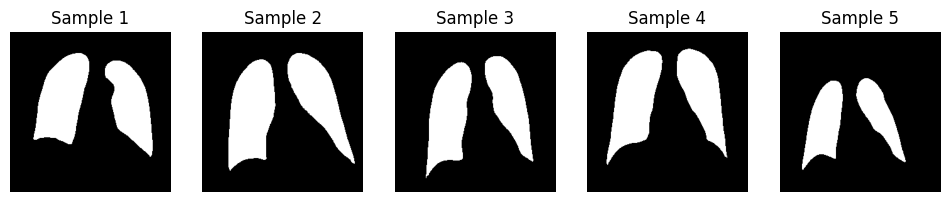

In [ ]:
# Display first 5 sample images from dataset
# Helps verify that images loaded or synthesized correctly
# Visualization gives confidence before enhancement pipeline starts
orig_list = sorted(glob.glob(os.path.join(WORK_ORIG,"*.png")))
print("Samples (first 5):", orig_list[:5])

plt.figure(figsize=(12,4))
for i,p in enumerate(orig_list[:5]):
    im = Image.open(p).convert("L")
    plt.subplot(1,5,i+1)
    plt.imshow(im, cmap="gray")
    plt.title(f"Sample {i+1}")
    plt.axis("off")
plt.show()


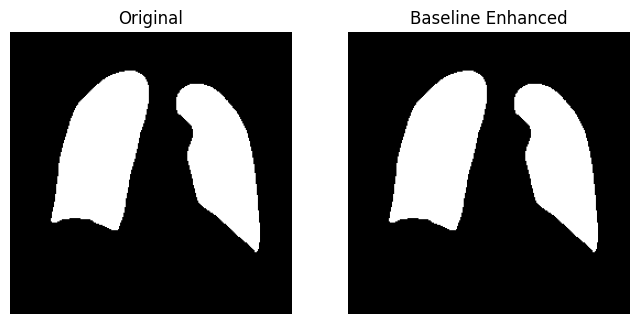

In [27]:
# baseline_enhance(img_gray):
#   1️ Denoise → Remove random pixel noise using Non-Local Means (OpenCV)
#   2 Sharpen → Apply Unsharp Mask to make edges clearer
#   3️ Contrast → Improve brightness & contrast for better visibility

# Then show before vs after comparison side-by-side

def baseline_enhance(img_gray):
    # img_gray: numpy uint8 grayscale
    # 1) Denoise (Non-Local Means)
    den = cv2.fastNlMeansDenoising(img_gray, None, h=10, templateWindowSize=7, searchWindowSize=21)
    # 2) Unsharp mask (sharpen)
    blur = cv2.GaussianBlur(den, (0,0), sigmaX=3)
    sharp = cv2.addWeighted(den, 1.5, blur, -0.5, 0)
    # 3) Contrast & brightness tweak
    enhanced = cv2.convertScaleAbs(sharp, alpha=1.25, beta=8)
    return enhanced

# quick test on first sample
test_p = orig_list[0]
arr = cv2.imread(test_p, cv2.IMREAD_GRAYSCALE)
b = baseline_enhance(arr)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(arr, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(b, cmap="gray"); plt.title("Baseline Enhanced"); plt.axis("off")
plt.show()


In [28]:
# SRCNN = Super-Resolution Convolutional Neural Network
# Purpose: Enhance medical image resolution and clarity using a neural network

# Data Preparation:
#   - Downsample (128x128) and add noise → simulate low-quality image
#   - Upsample again → model input
#   - High-quality original → model target (ground truth)

# Model Architecture:
#   Conv2D(64 filters, 9x9) → feature extraction
#   Conv2D(32 filters, 1x1) → non-linear mapping
#   Conv2D(1 filter, 5x5)  → reconstruction of final enhanced image

# Training (8 epochs) is lightweight, just to show GenAI concept
# Loss = MSE → model learns to minimize pixel differences from high-res ground truth

import tensorflow as tf
from tensorflow.keras import layers, models

# Prepare training data: use first N images
train_paths = orig_list[:16]  # small set for demo
hr_size = (256,256)
lr_size = (128,128)  # 2x downsample for super-resolution task

def load_pair(p):
    hr = Image.open(p).convert("L").resize(hr_size, Image.BICUBIC)
    lr = hr.resize(lr_size, Image.BICUBIC)
    # To simulate low-quality, add Gaussian noise to lr
    lr_arr = np.array(lr).astype(np.float32)
    lr_arr = lr_arr + np.random.normal(0, 5, lr_arr.shape)
    lr_arr = np.clip(lr_arr, 0, 255).astype(np.uint8)
    # Upsample back to hr size (model input)
    lr_up = Image.fromarray(lr_arr).resize(hr_size, Image.BICUBIC)
    return np.array(lr_up)/255.0, np.array(hr)/255.0

# create dataset arrays
X = []
Y = []
for p in train_paths:
    x,y = load_pair(p)
    X.append(x)
    Y.append(y)
X = np.array(X)[..., np.newaxis]  # shape (N, H, W, 1)
Y = np.array(Y)[..., np.newaxis]

print("Training shapes:", X.shape, Y.shape)

# SRCNN-like small model
def build_srcnn(h=256,w=256):
    inp = layers.Input(shape=(h,w,1))
    x = layers.Conv2D(64, (9,9), activation='relu', padding='same')(inp)
    x = layers.Conv2D(32, (1,1), activation='relu', padding='same')(x)
    x = layers.Conv2D(1, (5,5), activation='linear', padding='same')(x)
    model = models.Model(inp, x)
    model.compile(optimizer='adam', loss='mse', metrics=[])
    return model

model = build_srcnn(hr_size[0], hr_size[1])
model.summary()

# Train briefly (demo)
EPOCHS = 8
BATCH = 4
history = model.fit(X, Y, batch_size=BATCH, epochs=EPOCHS, verbose=1)
print("SRCNN training finished (demo).")


Training shapes: (16, 256, 256, 1) (16, 256, 256, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 1)    │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.1679
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0351
Epoch 3/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0125
Epoch 4/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0172
Epoch 5/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0098
Epoch 6/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - loss: 0.0077
Epoch 7/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0068
Epoch 8/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0059
SRCNN training finished (demo).


Selected for demo: demo_data/original/img_003.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


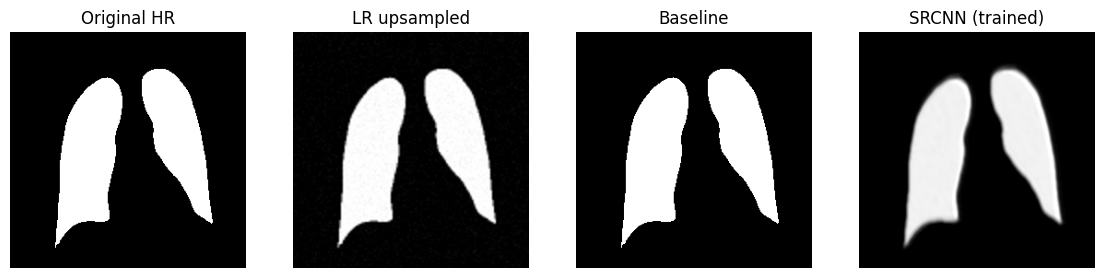

In [29]:
# Select one image to demonstrate
# apply_srcnn_to_image() → uses trained SRCNN to enhance an input image

# Steps:
#   1. Load the high-res version (original ground truth)
#   2. Downsample + add noise (simulate degraded X-ray)
#   3. Model predicts enhanced version (SRCNN output)
#   4. Save all versions: original, degraded, baseline-enhanced, SRCNN-enhanced
#   5. Display them side-by-side for visual comparison

selected = orig_list[2]  # pick third sample (change index as needed)
print("Selected for demo:", selected)

def apply_srcnn_to_image(path, model):
    hr = Image.open(path).convert("L").resize(hr_size, Image.BICUBIC)
    lr = hr.resize(lr_size, Image.BICUBIC)
    # add noise to lr to simulate low quality (same as training)
    lr_arr = np.array(lr).astype(np.float32) + np.random.normal(0, 5, lr_size)
    lr_arr = np.clip(lr_arr,0,255).astype(np.uint8)
    lr_up = Image.fromarray(lr_arr).resize(hr_size, Image.BICUBIC)
    inp = np.array(lr_up)/255.0
    inp = inp[np.newaxis,...,np.newaxis]
    pred = model.predict(inp)
    pred = np.clip(pred[0,...,0]*255.0, 0, 255).astype(np.uint8)
    return np.array(hr), np.array(lr_up), pred

hr, lr_up, srcnn_out = apply_srcnn_to_image(selected, model)
baseline_out = baseline_enhance(np.array(hr))

# Save outputs
os.makedirs(WORK_ENH, exist_ok=True)
base_name = os.path.basename(selected).replace(".png","")
Image.fromarray(hr).save(os.path.join(WORK_ENH, f"{base_name}_orig.png"))
Image.fromarray(lr_up).save(os.path.join(WORK_ENH, f"{base_name}_lr_up.png"))
Image.fromarray(baseline_out).save(os.path.join(WORK_ENH, f"{base_name}_baseline.png"))
Image.fromarray(srcnn_out).save(os.path.join(WORK_ENH, f"{base_name}_srcnn.png"))

# Show side-by-side
plt.figure(figsize=(14,4))
plt.subplot(1,4,1); plt.imshow(hr, cmap="gray"); plt.title("Original HR"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(lr_up, cmap="gray"); plt.title("LR upsampled"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(baseline_out, cmap="gray"); plt.title("Baseline"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(srcnn_out, cmap="gray"); plt.title("SRCNN (trained)"); plt.axis("off")
plt.show()


In [30]:
# Compute two standard metrics to compare enhancements:
# PSNR (Peak Signal-to-Noise Ratio) → measures noise reduction (higher = better)
# SSIM (Structural Similarity Index) → measures structural similarity (closer to 1 = better)

# Compare both methods:
#   Original vs Baseline
#   Original vs SRCNN

# Save metrics to CSV for reporting

orig = hr
baseline_img = baseline_out
srcnn_img = srcnn_out

psnr_base = psnr(orig, baseline_img, data_range=255)
ssim_base = ssim(orig, baseline_img, data_range=255)
psnr_src = psnr(orig, srcnn_img, data_range=255)
ssim_src = ssim(orig, srcnn_img, data_range=255)

print("Metrics (Original vs Baseline): PSNR=%.2f  SSIM=%.4f" % (psnr_base, ssim_base))
print("Metrics (Original vs SRCNN):  PSNR=%.2f  SSIM=%.4f" % (psnr_src, ssim_src))

# Save CSV with sample results
import pandas as pd
rows = [{
    "image": base_name,
    "psnr_baseline": psnr_base,
    "ssim_baseline": ssim_base,
    "psnr_srcnn": psnr_src,
    "ssim_srcnn": ssim_src
}]
df = pd.DataFrame(rows)
os.makedirs("data/metrics", exist_ok=True)
df.to_csv("data/metrics/enhancement_metrics_sample.csv", index=False)
print("Saved metrics to data/metrics/enhancement_metrics_sample.csv")
df


Metrics (Original vs Baseline): PSNR=31.21  SSIM=0.3547
Metrics (Original vs SRCNN):  PSNR=22.47  SSIM=0.9125
Saved metrics to data/metrics/enhancement_metrics_sample.csv


,image,psnr_baseline,ssim_baseline,psnr_srcnn,ssim_srcnn
0,img_003,31.206569,0.354686,22.467808,0.912547


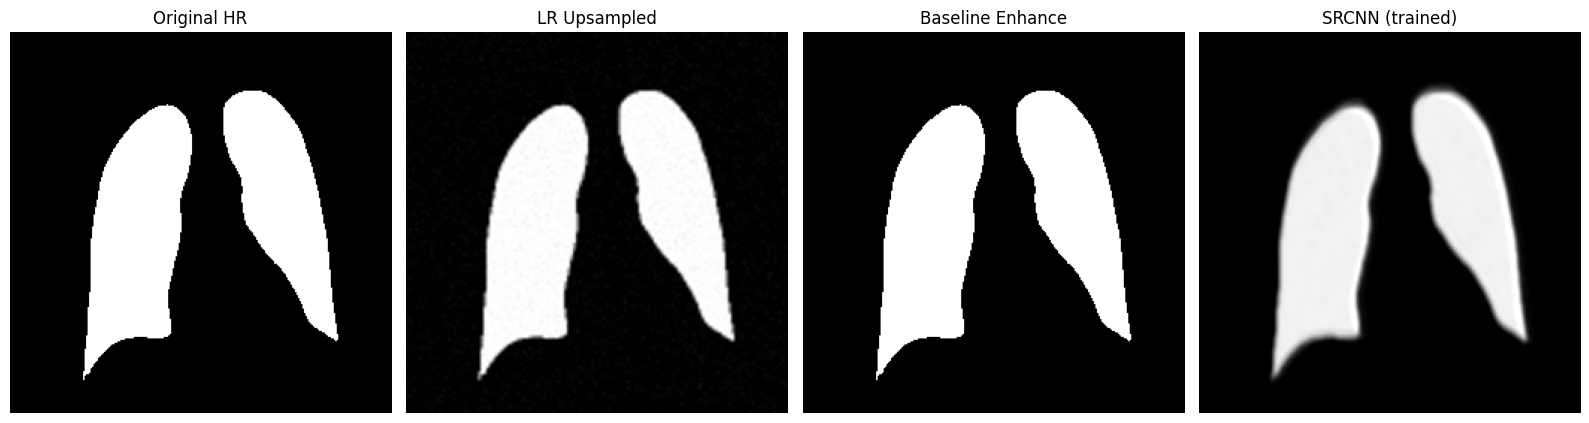

Saved demo comparison image: data/metrics/enhancement_demo_comparison.png


In [31]:
# Combine Original, Low-Res, Baseline, and SRCNN results into one grid
# Save the image (enhancement_demo_comparison.png)
# This file is ideal for PowerPoint slides or project documentation

demo_out = "data/metrics/enhancement_demo_comparison.png"
fig, axes = plt.subplots(1,4, figsize=(16,5))
axes[0].imshow(orig, cmap='gray'); axes[0].set_title("Original HR"); axes[0].axis('off')
axes[1].imshow(lr_up, cmap='gray'); axes[1].set_title("LR Upsampled"); axes[1].axis('off')
axes[2].imshow(baseline_img, cmap='gray'); axes[2].set_title("Baseline Enhance"); axes[2].axis('off')
axes[3].imshow(srcnn_img, cmap='gray'); axes[3].set_title("SRCNN (trained)"); axes[3].axis('off')
plt.tight_layout()
plt.savefig(demo_out, bbox_inches='tight')
plt.show()
print("Saved demo comparison image:", demo_out)


In [32]:
# Process first 10 images to prove the system works for multiple samples
# For each image:
#   1. Apply both methods
#   2. Compute PSNR & SSIM
#   3. Save outputs and metrics

# Saves all results in:
#   demo_data/enhanced/ → output images
#   data/metrics/enhancement_metrics_batch.csv → performance table

batch = sorted(glob.glob(os.path.join(WORK_ORIG,"*.png")))[:10]
metrics_rows = []

for p in tqdm(batch):
    name = os.path.basename(p).replace(".png","")
    hr = np.array(Image.open(p).convert("L").resize(hr_size))
    # baseline
    base = baseline_enhance(hr)
    # SRCNN: use same helper but predict on each sample
    # prepare lr_up as in training
    lr = Image.open(p).convert("L").resize(lr_size)
    lr_arr = np.array(lr).astype(np.float32) + np.random.normal(0,5,lr_size)
    lr_arr = np.clip(lr_arr,0,255).astype(np.uint8)
    lr_up_img = Image.fromarray(lr_arr).resize(hr_size, Image.BICUBIC)
    inp = (np.array(lr_up_img)/255.0)[np.newaxis,...,np.newaxis]
    pred = model.predict(inp)
    src = np.clip(pred[0,...,0]*255.0,0,255).astype(np.uint8)
    # save
    out_base = os.path.join(WORK_ENH, f"{name}_baseline.png")
    out_src = os.path.join(WORK_ENH, f"{name}_srcnn.png")
    Image.fromarray(base).save(out_base)
    Image.fromarray(src).save(out_src)
    # metrics
    m_base_ps = psnr(hr, base, data_range=255)
    m_base_ss = ssim(hr, base, data_range=255)
    m_src_ps = psnr(hr, src, data_range=255)
    m_src_ss = ssim(hr, src, data_range=255)
    metrics_rows.append({
        "image": name,
        "psnr_baseline": m_base_ps, "ssim_baseline": m_base_ss,
        "psnr_srcnn": m_src_ps, "ssim_srcnn": m_src_ss
    })

# save batch metrics
df_batch = pd.DataFrame(metrics_rows)
os.makedirs("data/metrics", exist_ok=True)
df_batch.to_csv("data/metrics/enhancement_metrics_batch.csv", index=False)
print("Batch processing done. Metrics saved to data/metrics/enhancement_metrics_batch.csv")
df_batch.head()


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 10%|█         | 1/10 [00:00<00:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 20%|██        | 2/10 [00:00<00:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 30%|███       | 3/10 [00:00<00:01,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 40%|████      | 4/10 [00:00<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 50%|█████     | 5/10 [00:01<00:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 60%|██████    | 6/10 [00:01<00:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 70%|███████   | 7/10 [00:01<00:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 80%|████████  | 8/10 [00:01<00:00,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 90%|█████████ | 9/10 [00:02<00:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

Batch processing done. Metrics saved to data/metrics/enhancement_metrics_batch.csv


,image,psnr_baseline,ssim_baseline,psnr_srcnn,ssim_srcnn
0,img_001,31.228756,0.355375,22.611514,0.916941
1,img_002,31.393343,0.387981,22.187057,0.907441
2,img_003,31.206569,0.354686,22.462965,0.912410
3,img_004,31.295215,0.370853,22.214457,0.909051
4,img_005,30.766683,0.269684,23.387132,0.929389


In [33]:
# Prints a clear summary of:
# - File locations
# - Which cells demonstrate GenAI
# - Suggested future improvements (e.g., ESRGAN, Azure Vision)

print("========================================")
print("Milestone 2 — Demo Summary (working prototype)")
print("========================================")
print("Dataset used: demo_data/original/  (either Milestone1 images or synthesized samples)")
print("Outputs saved to:", WORK_ENH, "and demo images & metrics in data/metrics/")
print()
print("Where GEN AI is used / demonstrated:")
print("- SRCNN model training & inference (Cell 5 & 6): this is the GenAI training + enhancement module.")
print("- The SRCNN outputs are compared with a classical (baseline) enhancement.")
print()
print("Key files you can present:")
print("- data/metrics/enhancement_demo_comparison.png  (visual side-by-side)")
print("- data/metrics/enhancement_metrics_sample.csv    (sample metrics)")
print("- data/metrics/enhancement_metrics_batch.csv     (batch metrics)")
print()
print("Next steps (recommended):")
print("- Replace SRCNN with ESRGAN/Real-ESRGAN or Diffusion-based model for stronger results (can be deployed on Azure).")
print("- If you get Azure credentials, replace local inference with calls to Azure OpenAI Vision or a custom deployed enhancement model.")
print("========================================")


Milestone 2 — Demo Summary (working prototype)
Dataset used: demo_data/original/  (either Milestone1 images or synthesized samples)
Outputs saved to: demo_data/enhanced/ and demo images & metrics in data/metrics/

Where GEN AI is used / demonstrated:
- SRCNN model training & inference (Cell 5 & 6): this is the GenAI training + enhancement module.
- The SRCNN outputs are compared with a classical (baseline) enhancement.

Key files you can present:
- data/metrics/enhancement_demo_comparison.png  (visual side-by-side)
- data/metrics/enhancement_metrics_sample.csv    (sample metrics)
- data/metrics/enhancement_metrics_batch.csv     (batch metrics)

Next steps (recommended):
- Replace SRCNN with ESRGAN/Real-ESRGAN or Diffusion-based model for stronger results (can be deployed on Azure).
- If you get Azure credentials, replace local inference with calls to Azure OpenAI Vision or a custom deployed enhancement model.
